In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../')
import os
os.chdir('..')

import tensorflow as tf
import numpy as np
import librosa
import scipy 
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops

In [2]:
tf.reset_default_graph()

import pickle

from architecture.contextEncoderArchitecture import ContextEncoderArchitecture
from system.contextEncoderSystem import ContextEncoderSystem
from system.magPreAndPostProcessor import MagPreAndPostProcessor

architecturesParametersFile = "magnitude_network_parameters.pkl"
sessionsName = "Papers_FMAMag_Context_Encoder"

with open(architecturesParametersFile, 'rb') as savedFile:
    Context_Encoder_parameters = pickle.load(savedFile)

aContextEncoderArchitecture = ContextEncoderArchitecture(*Context_Encoder_parameters.architectureParameters())
aPreProcessor = MagPreAndPostProcessor(*Context_Encoder_parameters.preProcessorParameters())
aContextEncoderSystem = ContextEncoderSystem(aContextEncoderArchitecture, Context_Encoder_parameters.batchSize(),
                                             aPreProcessor, sessionsName)


---------
Encoder
---------
Tensor("ContextEncoderArchitecture/input_data:0", shape=(256, 16, 257, 4), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_0/Conv2D:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization/cond/Merge:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_1/Conv2D:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_1:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization_2/cond/Merge:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_2/Conv2D:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_2:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalizatio

In [3]:
sr = 16000
start_in_seconds = 0.1
gap_length = 1024
side_length = 2048

starting_sample_left_side = int(sr*start_in_seconds)
ending_sample_left_side = starting_sample_left_side + side_length
starting_sample_right_side = ending_sample_left_side + gap_length
ending_sample_right_side = starting_sample_right_side + side_length

best_step = 701261 # trained only on FMA


batch_size = 256

In [4]:
def _pavlovs_SNR(y_orig, y_inp, onAxis=(1,)):
    norm_y_orig = _squaredEuclideanNorm(y_orig, onAxis)
    norm_y_orig_minus_y_inp = _squaredEuclideanNorm(y_orig - y_inp, onAxis)
    return 10 * np.log10(norm_y_orig / norm_y_orig_minus_y_inp)

def _squaredEuclideanNorm(vector, onAxis=(1,)):
    squared = np.square(vector)
    summed = np.sum(squared, axis=onAxis)
    return summed


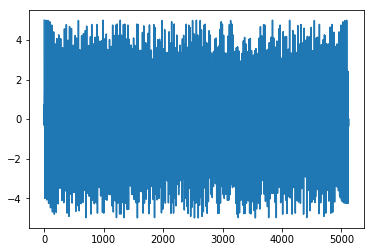

In [5]:
t = np.arange(0, 5120/sr, 1/sr)

freqs = [100, 200, 400, 800, 1600, 3200, 6400]

signal = scipy.signal.chirp(t, 500, 5120/sr, 1000, method='linear')
for i in range(1,5):
    signal += scipy.signal.chirp(t, 500*(3*i+1), 5120/sr, 500*(3*i+2), method='linear')
    
plt.plot(signal)
examples=signal


In [6]:
IPython.display.Audio(signal, rate=sr)


In [99]:
import scipy.io
scipy.io.savemat('magnitude_linear_chirp.mat', dict(examples=np.array([examples])))
np.array([examples]).shape

(1, 5120)

In [7]:
lpc_time = scipy.io.loadmat('lpc_linear_chirp.mat')['out']

In [8]:
lpc_time.shape

(1, 5120)

In [9]:
with tf.Session() as sess:
    tf_lpc_stft = tf.abs(tf.contrib.signal.stft(signals=lpc_time, frame_length=512, frame_step=128))
    lpc_stft = sess.run(tf_lpc_stft)
# lpc_time.shape

In [10]:
lpc_stft.shape

(1, 37, 257)

In [11]:
generatedSpecs = aContextEncoderSystem.reconstructAudio(np.repeat(np.array([examples]), [256], axis=0), model_num=best_step)
generatedSpecs[0][generatedSpecs[0]<=0] = 1e-10
generatedSpecs[1][generatedSpecs[1]<=0] = 1e-10
# generatedSpecs[2][generatedSpecs[2]<=0] = 1e-10
SNRs = _pavlovs_SNR(generatedSpecs[1], generatedSpecs[0], onAxis=(1, 2, 3))

print(np.mean(SNRs))
print(np.std(SNRs))
print(np.max(SNRs))
print(np.min(SNRs))

INFO:tensorflow:Restoring parameters from utils/saved_models/Papers_FMAMag_Context_Encoder/model-Papers_FMAMag_Context_Encoder701261.ckpt
Model restored.
1.5074401
4.4203986e-07
1.507441
1.5074391


In [12]:
left_context = np.abs(generatedSpecs[2][:,:-3,:,0] + 1.0j*generatedSpecs[2][:,:-3,:,1])
right_context = np.abs(generatedSpecs[2][:,3:,:,2] + 1.0j*generatedSpecs[2][:,3:,:,3])
left_context[left_context<=0] = 1e-10
right_context[right_context<=0] = 1e-10

In [13]:
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 36}
import matplotlib
matplotlib.rc('font', **font)

def plot(left_context, right_context, original_stft, CE_stft, lpc_stft):
    f, axarr = plt.subplots(1, 3, sharey='row', figsize=(24, 12))
    print(_pavlovs_SNR(original_stft, CE_stft, onAxis=(0, 1)))
    print(_pavlovs_SNR(original_stft, lpc_stft[13:24, :], onAxis=(0, 1)))
    
    original_stft = np.concatenate([left_context, original_stft, right_context], axis=0)
    CE_stft = np.concatenate([left_context, CE_stft, right_context], axis=0)

    z_max = np.max([np.max(np.log10(original_stft)), np.max(np.log10(CE_stft))])
    z_min = z_max-1.5
    print('max', z_max)

    yticks = [0, 33, 65, 128, 256]
    yticks_labels = ['0', '1', '2', '4', '8']
    plt.yticks(yticks, yticks_labels);
    axarr[0].set_ylabel('Frequency [kHz]')
    
    axarr[0].pcolormesh(np.log10(original_stft).transpose(), vmin=z_min, vmax=z_max)
    axarr[0].plot([13, 13], [0, 255], 'r--', lw=2)
    axarr[0].plot([13+11, 13+11], [0, 255], 'r--', lw=2)
    axarr[1].pcolormesh(np.log10(CE_stft).transpose(), vmin=z_min, vmax=z_max)
    axarr[1].plot([13, 13], [0, 255], 'r--', lw=2)
    axarr[1].plot([13+11, 13+11], [0, 255], 'r--', lw=2)
    axarr[2].pcolormesh(np.log10(lpc_stft).transpose(), vmin=z_min, vmax=z_max)
    axarr[2].plot([13, 13], [0, 255], 'r--', lw=2)
    axarr[2].plot([13+11, 13+11], [0, 255], 'r--', lw=2)
    
    xticks = [0, 13, 24, 37]
    axarr[0].set(xticks=xticks);
    axarr[1].set(xticks=xticks);
    axarr[2].set(xticks=xticks);

#     plt.savefig('chirp.pdf', bbox_inches='tight')



1.507439911365509
-1.3205033540725708
max 2.0990467446648173


/home/amarafioti/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


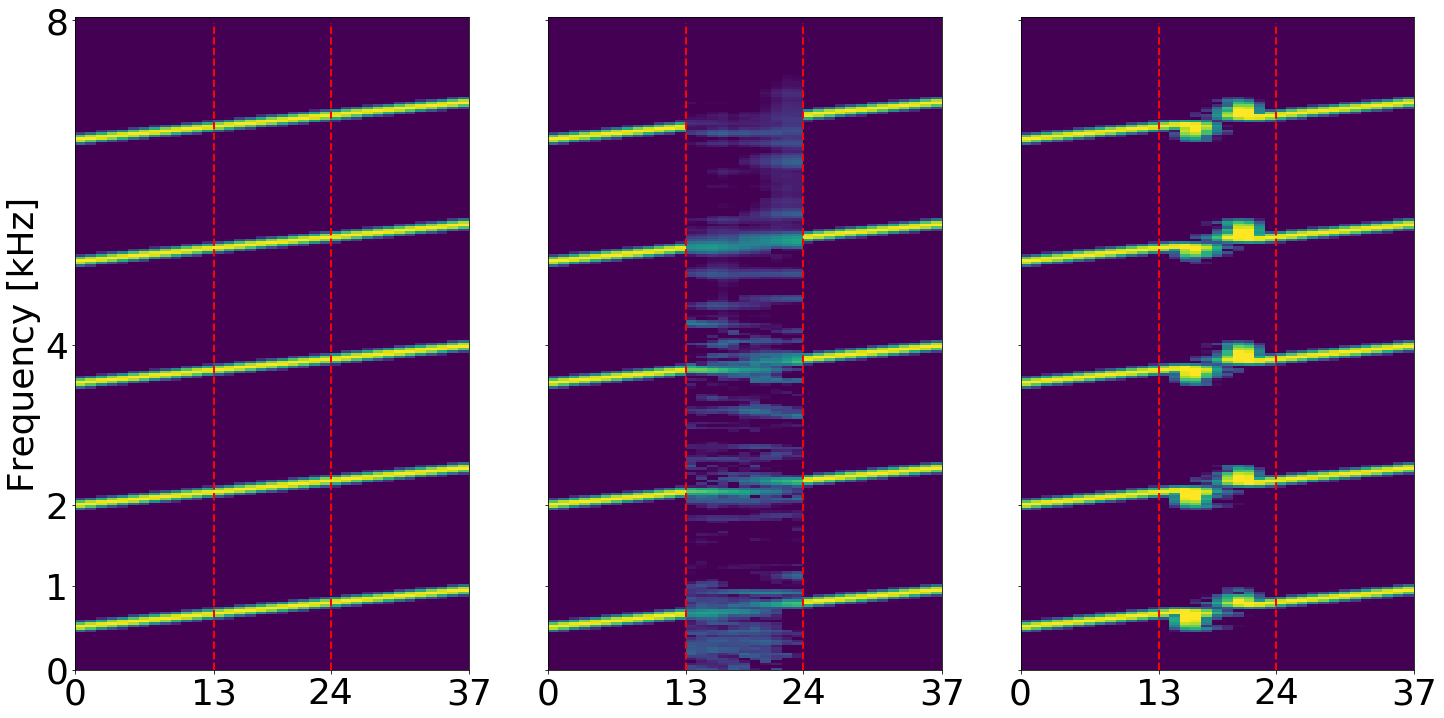

In [14]:
plot(left_context[0], right_context[0], generatedSpecs[1][0,:,:,0], generatedSpecs[0][0,:,:,0], lpc_stft[0, :, :])